# Imports:

In [60]:
# Makes sure to reload modules when they change
%load_ext autoreload
%autoreload 2

# --- Standard Library Imports ---
import os
import joblib
from PIL import Image, ImageOps

# --- Third-Party Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.amp import GradScaler, autocast
import torch

# --- Custom Imports ---
from src.utils import (
    extractCoordinates, aspect_crop, haversine_distance,
    plot_images_from_dataloader, setup_TensorBoard_writers,
    log_error_map, create_interactive_heatmap
)
from src.dataset import GeolocalizationDataset
from src.models import ConvNet, ConvNet2, ConvNet3, MultiTaskDINOGeo

# Enable CUDA optimizations
torch.backends.cudnn.benchmark = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Image preprocessing:

In [8]:
# Setup paths
RAW_IMAGE_FOLDER = r"data"             # Use original images for GPS extraction
PROCESSED_IMAGE_FOLDER = r"data_processed" # Use processed images for training

if not os.path.exists(PROCESSED_IMAGE_FOLDER) or len(os.listdir(PROCESSED_IMAGE_FOLDER)) < 1479:
    os.makedirs(PROCESSED_IMAGE_FOLDER, exist_ok=True)

    print("Starting Pre-processing...")
    files = [f for f in os.listdir(RAW_IMAGE_FOLDER) if f.lower().endswith(('.jpg', '.jpeg'))]

    for filename in tqdm(files):
        src_path = os.path.join(RAW_IMAGE_FOLDER, filename)
        dst_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
        
        try:
            with Image.open(src_path) as img:
                img = ImageOps.exif_transpose(img)
                img = img.convert('RGB')
                img = aspect_crop(img) 
                img = img.resize((192, 256), Image.Resampling.LANCZOS)
                img.save(dst_path, quality=95)
        except Exception as e:
            print(f"Failed {filename}: {e}")
else:
    print("Pre-processed images already exist. Skipping preprocessing step.")

Pre-processed images already exist. Skipping preprocessing step.


# Data loading:

In [33]:
if __name__ == "__main__":

    SCALER_SAVE_PATH = 'coordinate_scaler.pkl'

    # --- 2. EXTRACTION PHASE ---
    processed_data = []

    for filename in os.listdir(RAW_IMAGE_FOLDER):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            raw_image_path = os.path.join(RAW_IMAGE_FOLDER, filename)
            processed__image_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
            
            # Check if the processed version actually exists
            if not os.path.exists(processed__image_path):
                continue
                
            # Extract coordinates from the ORIGINAL file
            coords = extractCoordinates(raw_image_path)
            
            if coords:
                processed_data.append({
                    'path': processed__image_path, 
                    'lat': coords[0], 
                    'lon': coords[1]
                })

    df = pd.DataFrame(processed_data)
    
    # Keep 20% of the data for validation
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # --- 3. SCALING PHASE ---
    # must fit on training data *only*
    scaler = MinMaxScaler()
    train_df[['lat', 'lon']] = scaler.fit_transform(train_df[['lat', 'lon']])
    val_df[['lat', 'lon']] = scaler.transform(val_df[['lat', 'lon']])

    joblib.dump(scaler, SCALER_SAVE_PATH)

## Clustering for multi-task training:

Generating Zone Labels on Normalized Data...


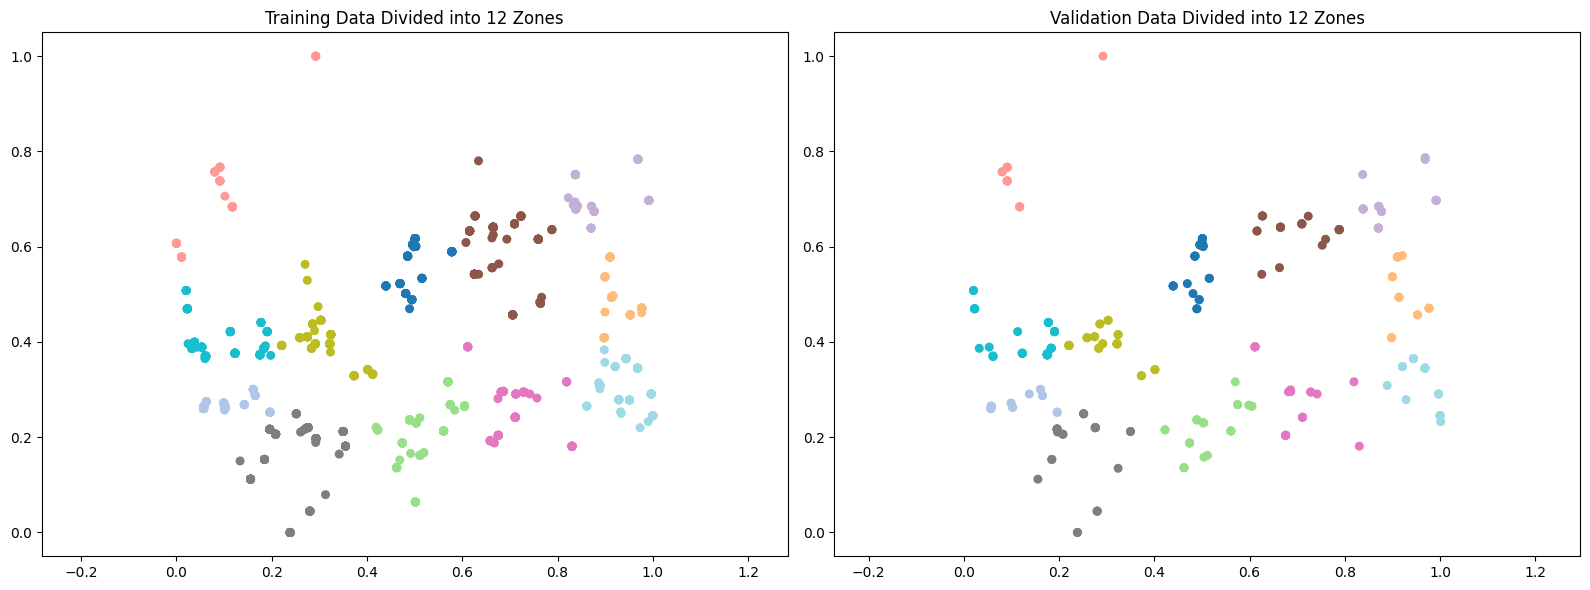

In [70]:
from sklearn.cluster import KMeans

print("Generating Zone Labels on Normalized Data...")

NUM_ZONES = 12 

kmeans = KMeans(n_clusters=NUM_ZONES, random_state=42, n_init=10)

# Fit on the normalized coordinates
train_df['zone_label'] = kmeans.fit_predict(train_df[['lat', 'lon']])
val_df['zone_label'] = kmeans.predict(val_df[['lat', 'lon']])

# plot the zones to see if they look reasonable for both training and validation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training data plot
axes[0].scatter(train_df['lon'], train_df['lat'], c=train_df['zone_label'], cmap='tab20', s=30)
axes[0].set_title(f"Training Data Divided into {NUM_ZONES} Zones")
axes[0].axis('equal')  # Keep aspect ratio so it looks like a map

# Validation data plot
axes[1].scatter(val_df['lon'], val_df['lat'], c=val_df['zone_label'], cmap='tab20', s=30)
axes[1].set_title(f"Validation Data Divided into {NUM_ZONES} Zones")
axes[1].axis('equal')  # Keep aspect ratio so it looks like a map

plt.tight_layout()
plt.show()

# Plot heatmap based on training data

In [66]:
train_coords = scaler.inverse_transform(train_df[['lat', 'lon']].values)
create_interactive_heatmap(train_coords, output_file='train_data_heatmap.html')

Heatmap saved to train_data_heatmap.html


Initializing train dataset...
Caching 1183 images in RAM...


100%|██████████| 1183/1183 [00:03<00:00, 335.33it/s]


Initializing validation dataset...
Caching 296 images in RAM...


100%|██████████| 296/296 [00:00<00:00, 331.09it/s]


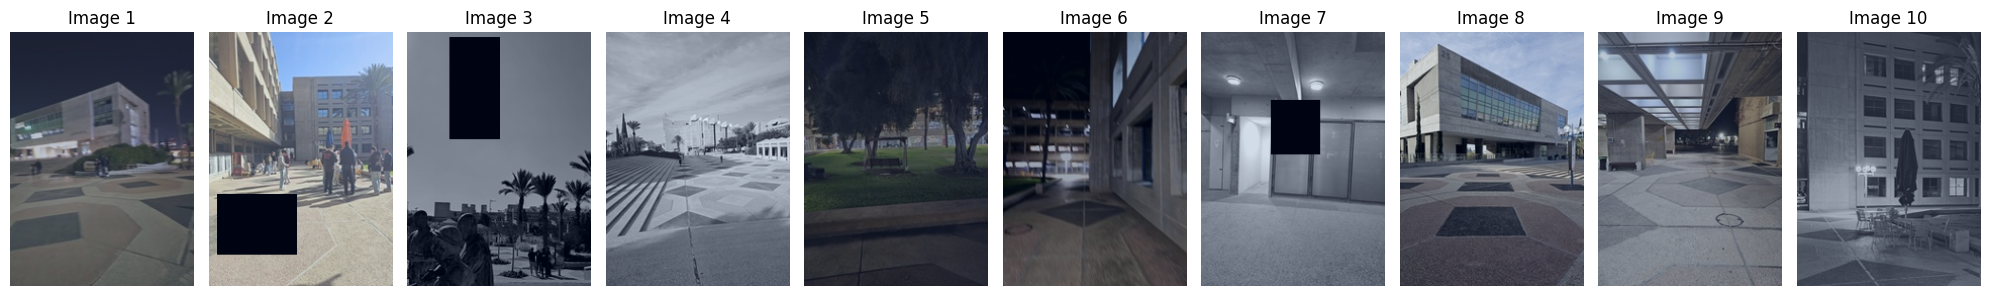

In [78]:
if __name__ == "__main__":

    # --- 4. DATASET INITIALIZATION ---
    print("Initializing train dataset...")
    train_dataset = GeolocalizationDataset(
        image_paths=train_df['path'].tolist(),
        coordinates=train_df[['lat', 'lon']].values,
        zone_labels=train_df['zone_label'].values,
        is_train=True,
        target_size=(252, 182)
    )
    print("Initializing validation dataset...")
    val_dataset = GeolocalizationDataset(
        image_paths=val_df['path'].tolist(),
        coordinates=val_df[['lat', 'lon']].values,
        zone_labels=val_df['zone_label'].values,
        is_train=False,
        target_size=(252, 182)
    )

    # --- 5. THE DATALOADER ---
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=0, 
        pin_memory=True)
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=0, 
        pin_memory=False)
    
    plot_images_from_dataloader(train_loader)

# Model setup:

In [90]:
# --- 6. INITIALIZE MODEL ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_rtx = "RTX" in torch.cuda.get_device_name(0)
print("Using device:", device)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))

model = MultiTaskDINOGeo(NUM_ZONES).to(device)

if is_rtx:
    model = model.to(memory_format=torch.channels_last) # Optimize for modern GPUs that prefer channels_last
else:
    print("RTX card not detected: Disabling AMP/Channels_Last optimizations")
    model = model.to(device)

# --- 7. LOSS & OPTIMIZER ---
patience_counter = 0
early_stopping_patience = 10
epochs = 100
use_TensorBoard = True # Set to False to disable TensorBoard logging

criterion_reg = torch.nn.HuberLoss(delta=1.0)
criterion_cls = torch.nn.CrossEntropyLoss(label_smoothing=0.15)
optimizer = torch.optim.AdamW([
    {'params': model.backbone.parameters(), 'lr': 1e-5}, # Slow backbone
    {'params': model.shared.parameters(),   'lr': 5e-4}, # Medium shared
    {'params': model.reg_head.parameters(), 'lr': 1e-3}, # Fast Head
    {'params': model.cls_head.parameters(), 'lr': 1e-3}  # Fast Head
], weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[1e-5, 5e-4, 1e-3, 1e-3], # One max_lr per group above
    steps_per_epoch=len(train_loader),
    epochs=epochs
)

print(f"Training on {len(train_dataset)} images, Validating on {len(val_dataset)} images.")

Using device: cuda
CUDA available: True
GPU: NVIDIA GeForce GTX 1070


Using cache found in C:\Users\013ri/.cache\torch\hub\facebookresearch_dinov2_main


RTX card not detected: Disabling AMP/Channels_Last optimizations
Training on 1183 images, Validating on 296 images.


# Model training:

In [91]:
# --- 8. TRAINING & VALIDATION LOOP ---
train_losses = []
val_losses = []
val_dist_history = []
val_zone_accuracy = []
learning_rates = []
best_dist = float("inf")

if use_TensorBoard:
    writer_train, writer_val = setup_TensorBoard_writers()

print(f"Starting training on {device}...")

gradScaler = GradScaler('cuda') #scaler for mixed precision training, prevents gradient underflow

for epoch in range(epochs):
    # --- PHASE 1: TRAINING ---
    model.train()  # Dropout ON
    train_running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False, unit="batch", mininterval=0.5)
    
    for images, labels_coords, labels_zones in pbar:
        # non_blocking=True speeds up RAM-to-VRAM transfer
        images = images.to(device, non_blocking=True)
        labels_coords = labels_coords.to(device, non_blocking=True)
        labels_zones = labels_zones.to(device, non_blocking=True)
        
        if is_rtx: # Optimize for RTX GPUs that prefer channels_last
            images = images.to(memory_format=torch.channels_last)

        optimizer.zero_grad(set_to_none=True)

        if is_rtx: # Use Mixed Precision Training only on RTX cards
            with autocast('cuda', dtype=torch.float16):
                pred_coords, pred_zones = model(images)
                
                loss_reg = criterion_reg(pred_coords, labels_coords)
                loss_cls = criterion_cls(pred_zones, labels_zones)

                loss = loss_reg + (0.5 * loss_cls)

            gradScaler.scale(loss).backward() 
            gradScaler.step(optimizer)        
            gradScaler.update()  

        else: # Standard training for non-RTX cards
            pred_coords, pred_zones = model(images)

            loss_reg = criterion_reg(pred_coords, labels_coords)
            loss_cls = criterion_cls(pred_zones, labels_zones)

            loss = loss_reg + (0.5 * loss_cls)

            loss.backward()
            optimizer.step()

        scheduler.step() # OneCycleLR steps after every batch
        train_running_loss += loss.item()

    # --- PHASE 2: VALIDATION ---
    model.eval()  # Set model to evaluation mode (disables Dropout)
    val_running_loss = 0.0
    correct_zones = 0
    raw_preds_coords = []
    raw_trues_coords = []

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for images, labels_coords, labels_zones in val_loader:
            #todo: channels last?
            images = images.to(device, non_blocking=True)
            labels_coords = labels_coords.to(device, non_blocking=True)
            labels_zones = labels_zones.to(device, non_blocking=True)

            # Standard Prediction and MSE Loss
            pred_coords, pred_zones = model(images)
            loss_reg = criterion_reg(pred_coords, labels_coords)
            loss_cls = criterion_cls(pred_zones, labels_zones)
            val_running_loss += (loss_reg + 0.5 * loss_cls).item()

            raw_preds_coords.append(pred_coords.cpu().numpy())
            raw_trues_coords.append(labels_coords.cpu().numpy())

            predicted_zones = torch.argmax(pred_zones, dim=1)
            correct_zones += (predicted_zones == labels_zones).sum().item()

    full_preds_raw = np.vstack(raw_preds_coords)
    full_trues_raw = np.vstack(raw_trues_coords)
    real_preds = scaler.inverse_transform(full_preds_raw)
    real_trues = scaler.inverse_transform(full_trues_raw)


    # --- PHASE 3: METRICS CALCULATION & PRINTING ---
    distances = haversine_distance(real_preds, real_trues)
    avg_dist_error = np.mean(distances)
    zone_accuracy = correct_zones / len(val_dataset) * 100.0
    
    avg_train_loss = train_running_loss / len(train_loader)
    avg_val_loss = val_running_loss / len(val_loader)
    current_lr = scheduler.get_last_lr()[0]

    if epoch % 15 == 0: # log error map every 15 epochs
        log_error_map(real_preds, real_trues, epoch, TB_writer = writer_val if use_TensorBoard else None)

    if use_TensorBoard:     # Write to TensorBoard
        writer_train.add_scalar('MSE Loss', avg_train_loss, epoch)
        writer_val.add_scalar('MSE Loss', avg_val_loss, epoch)
        writer_val.add_scalar('Metrics/Distance_Error_Meters', avg_dist_error, epoch)
        writer_val.add_scalar('Metrics/Zone_Accuracy_Percent', zone_accuracy, epoch)
        writer_train.add_scalar('Hyperparameters/Learning_Rate', current_lr, epoch)

    else: # No TensorBoard: store in lists
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_dist_history.append(avg_dist_error)
        val_zone_accuracy.append(zone_accuracy)
        learning_rates.append(current_lr)
    
    print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f} | Val Loss {avg_val_loss:.4f} | "
          f"Dist Error {avg_dist_error:.1f}m | Zone Acc {zone_accuracy:.1f}%")

    # 2. Save the BEST version of YOUR model
    if avg_dist_error < best_dist:
        best_dist = avg_dist_error
        torch.save(model.state_dict(), "custom_geo_model_best.pth")
        patience_counter = 0
        print(f"  *** NEW BEST: {best_dist:.1f}m ***")
    else:
        patience_counter += 1
        print(f"(No improvement for {patience_counter}/{early_stopping_patience} epochs)")
         # 3. Early Stopping check
        if patience_counter >= early_stopping_patience:
            print("Model stopped improving. Ending training early.")
            break 

log_error_map(real_preds, real_trues, epoch, TB_writer = writer_val if use_TensorBoard else None) # final log

if use_TensorBoard:
    writer_train.close()
    writer_val.close()

Tensorboard - Logging to: runs/experiment_20260108_202156
Starting training on cuda...


Epoch 1: Train Loss 1.2404 | Val Loss 1.2153 | Dist Error 67.7m | Zone Acc 19.6%
  *** NEW BEST: 67.7m ***


Epoch 2: Train Loss 1.1680 | Val Loss 1.1589 | Dist Error 51.3m | Zone Acc 23.3%
  *** NEW BEST: 51.3m ***


Epoch 3: Train Loss 1.0973 | Val Loss 1.0915 | Dist Error 44.1m | Zone Acc 32.4%
  *** NEW BEST: 44.1m ***


Epoch 4: Train Loss 1.0163 | Val Loss 1.0170 | Dist Error 41.1m | Zone Acc 38.9%
  *** NEW BEST: 41.1m ***


Epoch 5: Train Loss 0.9341 | Val Loss 0.9647 | Dist Error 38.1m | Zone Acc 42.6%
  *** NEW BEST: 38.1m ***


Epoch 6: Train Loss 0.8709 | Val Loss 0.9313 | Dist Error 35.9m | Zone Acc 40.9%
  *** NEW BEST: 35.9m ***


Epoch 7: Train Loss 0.8164 | Val Loss 0.9007 | Dist Error 34.6m | Zone Acc 45.6%
  *** NEW BEST: 34.6m ***


Epoch 8: Train Loss 0.7713 | Val Loss 0.8871 | Dist Error 33.6m | Zone Acc 49.3%
  *** NEW BEST: 33.6m ***


Epoch 9: Train Loss 0.7274 | Val Loss 0.8782 | Dist Error 32.8m | Zone Acc 50.0%
  *** NEW BEST: 32.8m ***


Epoch 10: Train Loss 0.6838 | Val Loss 0.8645 | Dist Error 31.6m | Zone Acc 51.4%
  *** NEW BEST: 31.6m ***


Epoch 11: Train Loss 0.6528 | Val Loss 0.8426 | Dist Error 30.3m | Zone Acc 55.1%
  *** NEW BEST: 30.3m ***


Epoch 12: Train Loss 0.6211 | Val Loss 0.8759 | Dist Error 30.1m | Zone Acc 57.4%
  *** NEW BEST: 30.1m ***


Epoch 13: Train Loss 0.5816 | Val Loss 0.8779 | Dist Error 33.5m | Zone Acc 50.7%
(No improvement for 1/10 epochs)


Epoch 14: Train Loss 0.5492 | Val Loss 0.8392 | Dist Error 29.1m | Zone Acc 59.1%
  *** NEW BEST: 29.1m ***


Epoch 15: Train Loss 0.5270 | Val Loss 0.8637 | Dist Error 28.7m | Zone Acc 56.1%
  *** NEW BEST: 28.7m ***


Epoch 16: Train Loss 0.5177 | Val Loss 0.8580 | Dist Error 28.4m | Zone Acc 58.1%
  *** NEW BEST: 28.4m ***


Epoch 17: Train Loss 0.4965 | Val Loss 0.8574 | Dist Error 27.8m | Zone Acc 57.1%
  *** NEW BEST: 27.8m ***


Epoch 18: Train Loss 0.4835 | Val Loss 0.8991 | Dist Error 27.4m | Zone Acc 56.4%
  *** NEW BEST: 27.4m ***


Epoch 19: Train Loss 0.4792 | Val Loss 0.8776 | Dist Error 27.9m | Zone Acc 59.8%
(No improvement for 1/10 epochs)


Epoch 20: Train Loss 0.4719 | Val Loss 0.8480 | Dist Error 27.7m | Zone Acc 56.8%
(No improvement for 2/10 epochs)


Epoch 21: Train Loss 0.4623 | Val Loss 0.8350 | Dist Error 26.3m | Zone Acc 57.1%
  *** NEW BEST: 26.3m ***


Epoch 22: Train Loss 0.4539 | Val Loss 0.8648 | Dist Error 27.5m | Zone Acc 57.4%
(No improvement for 1/10 epochs)


Epoch 23: Train Loss 0.4446 | Val Loss 0.8227 | Dist Error 27.7m | Zone Acc 59.1%
(No improvement for 2/10 epochs)


Epoch 24: Train Loss 0.4324 | Val Loss 0.8474 | Dist Error 27.1m | Zone Acc 59.5%
(No improvement for 3/10 epochs)


Epoch 25: Train Loss 0.4378 | Val Loss 0.8292 | Dist Error 27.3m | Zone Acc 57.1%
(No improvement for 4/10 epochs)


Epoch 26: Train Loss 0.4276 | Val Loss 0.8295 | Dist Error 26.7m | Zone Acc 60.1%
(No improvement for 5/10 epochs)


Epoch 27: Train Loss 0.4308 | Val Loss 0.8409 | Dist Error 26.4m | Zone Acc 60.1%
(No improvement for 6/10 epochs)


Epoch 28: Train Loss 0.4267 | Val Loss 0.8520 | Dist Error 26.5m | Zone Acc 59.5%
(No improvement for 7/10 epochs)


Epoch 29: Train Loss 0.4257 | Val Loss 0.8386 | Dist Error 27.5m | Zone Acc 57.4%
(No improvement for 8/10 epochs)


Epoch 30: Train Loss 0.4174 | Val Loss 0.8334 | Dist Error 25.6m | Zone Acc 58.8%
  *** NEW BEST: 25.6m ***


Epoch 31: Train Loss 0.4134 | Val Loss 0.8318 | Dist Error 26.2m | Zone Acc 60.1%
(No improvement for 1/10 epochs)


Epoch 32: Train Loss 0.4134 | Val Loss 0.8190 | Dist Error 26.1m | Zone Acc 60.1%
(No improvement for 2/10 epochs)


Epoch 33: Train Loss 0.4135 | Val Loss 0.8200 | Dist Error 26.3m | Zone Acc 59.8%
(No improvement for 3/10 epochs)


Epoch 34: Train Loss 0.4069 | Val Loss 0.8211 | Dist Error 25.2m | Zone Acc 59.5%
  *** NEW BEST: 25.2m ***


Epoch 35: Train Loss 0.4047 | Val Loss 0.8162 | Dist Error 25.4m | Zone Acc 58.8%
(No improvement for 1/10 epochs)


Epoch 36: Train Loss 0.4052 | Val Loss 0.8369 | Dist Error 25.6m | Zone Acc 58.8%
(No improvement for 2/10 epochs)


Epoch 37: Train Loss 0.4025 | Val Loss 0.8090 | Dist Error 25.2m | Zone Acc 62.2%
  *** NEW BEST: 25.2m ***


Epoch 38: Train Loss 0.4003 | Val Loss 0.8334 | Dist Error 25.8m | Zone Acc 59.1%
(No improvement for 1/10 epochs)


Epoch 39: Train Loss 0.3987 | Val Loss 0.8197 | Dist Error 26.0m | Zone Acc 60.1%
(No improvement for 2/10 epochs)


Epoch 40: Train Loss 0.3955 | Val Loss 0.8360 | Dist Error 26.4m | Zone Acc 60.1%
(No improvement for 3/10 epochs)


Epoch 41: Train Loss 0.3972 | Val Loss 0.8392 | Dist Error 27.1m | Zone Acc 58.8%
(No improvement for 4/10 epochs)


Epoch 42: Train Loss 0.3945 | Val Loss 0.8371 | Dist Error 26.5m | Zone Acc 62.2%
(No improvement for 5/10 epochs)


Epoch 43: Train Loss 0.3956 | Val Loss 0.8168 | Dist Error 26.1m | Zone Acc 59.8%
(No improvement for 6/10 epochs)


Epoch 44: Train Loss 0.3946 | Val Loss 0.8158 | Dist Error 26.8m | Zone Acc 63.2%
(No improvement for 7/10 epochs)


Epoch 45: Train Loss 0.3954 | Val Loss 0.8070 | Dist Error 26.6m | Zone Acc 61.1%
(No improvement for 8/10 epochs)


Epoch 46: Train Loss 0.3899 | Val Loss 0.8107 | Dist Error 25.9m | Zone Acc 59.5%
(No improvement for 9/10 epochs)


Epoch 47: Train Loss 0.3908 | Val Loss 0.8115 | Dist Error 26.7m | Zone Acc 58.1%
(No improvement for 10/10 epochs)
Model stopped improving. Ending training early.


In [92]:
from sklearn.neighbors import KNeighborsRegressor

def evaluate_with_knn(model, train_loader, val_loader, k=3):
    model.eval()
    print("Building Feature Bank from Training Data...")
    
    # 1. Extract features for all TRAINING images
    X_train = []
    y_train = []
    with torch.no_grad():
        for images, coords, _ in tqdm(train_loader):
            images = images.to(device)
            # Use the backbone + shared layer (the "Smart" features)
            # We bypass the heads entirely
            features = model.shared(model.backbone(images))
            X_train.append(features.cpu().numpy())
            y_train.append(coords.numpy()) # Keep normalized coords
            
    X_train = np.vstack(X_train)
    y_train = np.vstack(y_train)
    
    # 2. Extract features for VALIDATION images
    print("Querying Validation Data...")
    X_val = []
    y_val = []
    with torch.no_grad():
        for images, coords, _ in tqdm(val_loader):
            images = images.to(device)
            features = model.shared(model.backbone(images))
            X_val.append(features.cpu().numpy())
            y_val.append(coords.numpy())
            
    X_val = np.vstack(X_val)
    y_val = np.vstack(y_val)

    # 3. Run k-NN (Cosine distance is usually best for DINO)
    knn = KNeighborsRegressor(n_neighbors=k, metric='cosine', weights='distance')
    knn.fit(X_train, y_train)
    preds = knn.predict(X_val)
    
    # 4. Calculate Real Error
    real_preds = scaler.inverse_transform(preds)
    real_trues = scaler.inverse_transform(y_val)
    distances = haversine_distance(real_preds, real_trues)
    
    print(f"=== k-NN Results (k={k}) ===")
    print(f"Error: {np.mean(distances):.1f} meters")

evaluate_with_knn(model, train_loader, val_loader, k=3)

Building Feature Bank from Training Data...


100%|██████████| 37/37 [00:07<00:00,  4.82it/s]


Querying Validation Data...


100%|██████████| 10/10 [00:01<00:00,  7.45it/s]


=== k-NN Results (k=3) ===
Error: 22.1 meters


# Plotting the results:

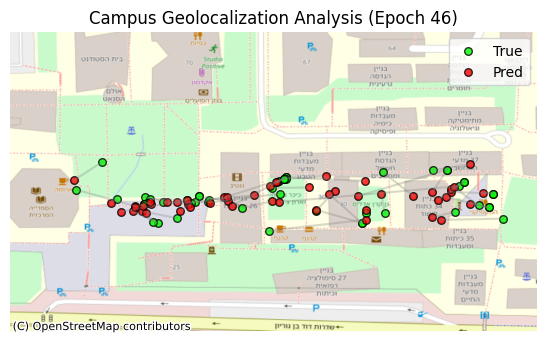

In [93]:
log_error_map(real_preds, real_trues, epoch,num_points= 50)

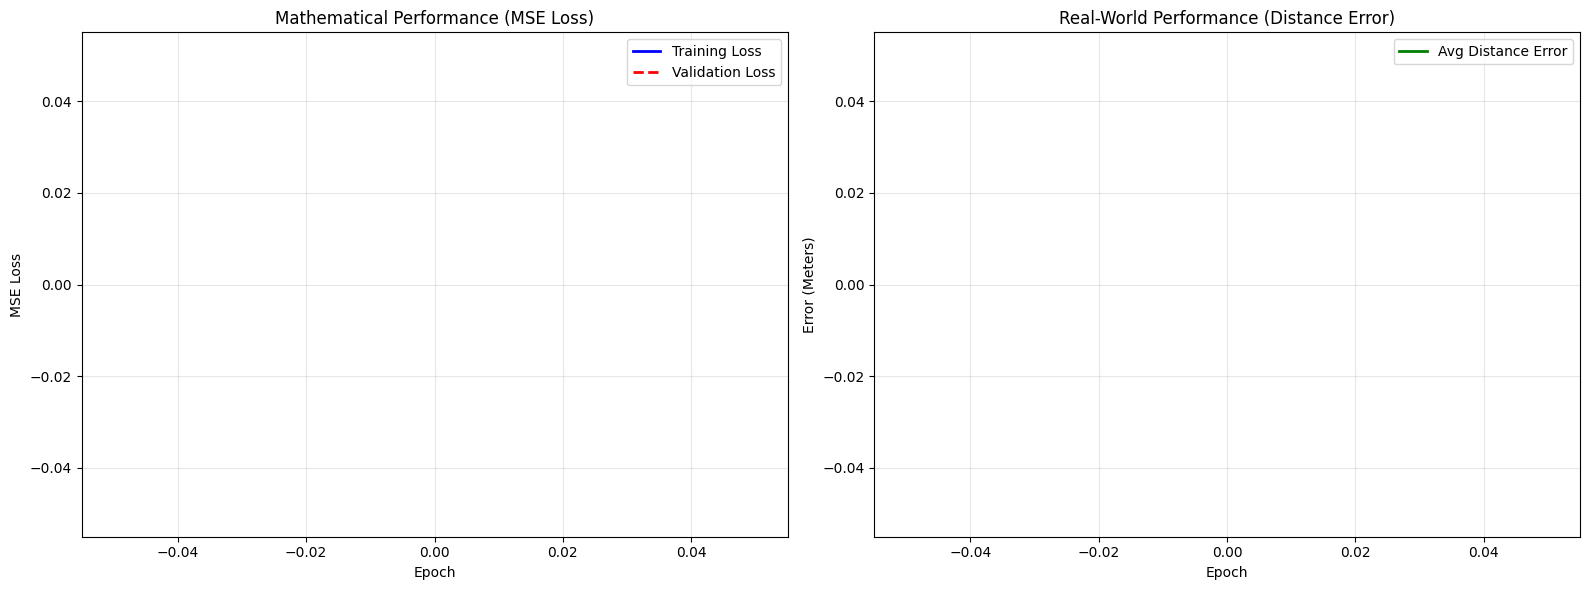


Training finished! Best Validation Error: 25.2 meters.
Model saved as 'geo_model.pth'


In [94]:
# --- 9. SAVE THE MODEL & GENERATE PLOTS ---

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left Plot: MSE Loss (Training vs Validation)
ax1.plot(train_losses, label="Training Loss", color="blue", linewidth=2)
ax1.plot(val_losses, label="Validation Loss", color="red", linestyle="--", linewidth=2)
ax1.set_title("Mathematical Performance (MSE Loss)")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right Plot: Physical Distance Error (Meters)
ax2.plot(val_dist_history, label="Avg Distance Error", color="green", linewidth=2)
ax2.set_title("Real-World Performance (Distance Error)")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Error (Meters)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the model weights
torch.save(model.state_dict(), "geo_model.pth")
print(f"\nTraining finished! Best Validation Error: {best_dist:.1f} meters.")
print("Model saved as 'geo_model.pth'")

In [95]:
""" # Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SCALER_PATH = 'coordinate_scaler.pkl'
MODEL_WEIGHTS_PATH = 'geo_model.pth'

# Loading Model and Scaler
# Initialize the model architecture and move to the device (GPU/CPU)
model = ConvNet2().to(device)

# Load the trained weights from the .pth file
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

# Set the model to evaluation mode (disables Dropout and Batchnorm layers)
model.eval()

# Load the MinMaxScaler used during training to reverse the normalization
scaler = joblib.load(SCALER_PATH)

# Image Preprocessing Function
def predict_location(image_path):

    # Load the image and ensure it is in RGB format
    img = Image.open(image_path).convert('RGB')
    
    # Apply the same validation transforms (No augmentations here!)
    preprocess = T.Compose([
        T.Resize(256),
        T.CenterCrop(256),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Add a batch dimension (Batch size of 1) and move the tensor to device
    img_tensor = preprocess(img).unsqueeze(0).to(device) 
    
    # Perform inference without calculating gradients
    with torch.no_grad():
        output = model(img_tensor)
    
    # Convert the prediction back to a NumPy array on the CPU
    prediction_normalized = output.cpu().numpy()
    
    # Reverse the scaling to get real-world GPS coordinates
    real_coords = scaler.inverse_transform(prediction_normalized)
    
    # Return the first (and only) result in the batch [Latitude, Longitude]
    return real_coords[0]

# Run Inference on a New Image
# Provide the full path to your local image file
test_path = r"C:\path\to\your\new\image.jpg"
lat, lon = predict_location(test_path)

print(f"Predicted Location: Latitude {lat:.6f}, Longitude {lon:.6f}")
print(f"Google Maps Link: http://maps.google.com/maps?q={lat},{lon}") """

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\013ri\AppData\Local\Temp\ipykernel_23308\333207449.py:1: SyntaxWarning: invalid escape sequence '\p'
  """ # Check if GPU is available, otherwise use CPU


' # Check if GPU is available, otherwise use CPU\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nSCALER_PATH = \'coordinate_scaler.pkl\'\nMODEL_WEIGHTS_PATH = \'geo_model.pth\'\n\n# Loading Model and Scaler\n# Initialize the model architecture and move to the device (GPU/CPU)\nmodel = ConvNet2().to(device)\n\n# Load the trained weights from the .pth file\nmodel.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))\n\n# Set the model to evaluation mode (disables Dropout and Batchnorm layers)\nmodel.eval()\n\n# Load the MinMaxScaler used during training to reverse the normalization\nscaler = joblib.load(SCALER_PATH)\n\n# Image Preprocessing Function\ndef predict_location(image_path):\n\n    # Load the image and ensure it is in RGB format\n    img = Image.open(image_path).convert(\'RGB\')\n\n    # Apply the same validation transforms (No augmentations here!)\n    preprocess = T.Compose([\n        T.Resize(256),\n        T.CenterCrop(256),\n        T.ToTensor(),\n        